# Transfer Learning on your Own Dataset

You will get to use the power of Transfer learning with **your own dataset**. So in this assignment you are going to retrain the pre-trained VGG16 Model with your own detectable objects. 

![](https://miro.medium.com/max/1000/0*xNjEPIZmPvKeqss6)

For doing so, you should :

* Generate a custom dataset, so take your own images from custom objects (or from the team members).  

* Be sure that you take the images from different angles and different distances, different lighting conditions and different backgrounds for each object. In other words, changing the environment where your objects are while training will lead to a better performance (generalization).

* Use at least 3 diffent opbjects (3 classes) and at most 10 classes where such dataset should have at least 50-100 images per class. (more images should lead to better detection performance) 

* Follow the workflow as [decribed before](https://keras.io/guides/transfer_learning/)

* Show the output of the different (training) steps and the resulting classification on unseen data and answer the related questions in the subsections below

---

### Use the following websites that take you trought all the steps of development.

The first page explains how to use the VGG-16 model with Keras to classify pre-tained images. 
> https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/





This second page explains the complete proces for classification of images using Keras, they start a problem desciption, data praparation, building a custom CNN model and then optimizing this model. After this they look at the same problem solving it with transfer learning. 

> https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/


You can start at the **"Explore Transfer Learning"** chapter, although you probably need to look back at earlier parts of this page.  

| NOTE: Finetuning by retraining all weights in the network as described in the workflow is Optional |
| --- |


```
Imad Hanzaz, Yannick Urselmann, Jaylong Verschuren
```

# Initialization

load all needed libraries and functions, 
check the previous tutorial how to correctly load keras and other modules

In [121]:
TrainModel = True
model_iteration = 6

In [122]:
import tensorflow as tf
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import PIL
from pathlib import Path
import imghdr
from os import listdir
from numpy import asarray
from numpy import save

print("Current Tensorflow version used is: " + tf.__version__)

Current Tensorflow version used is: 2.11.0


# Load dataset & Plot a subset

load your dataset and show a plot of the subset of your data



In [123]:
if TrainModel == True:
    traintest_data_dir = pathlib.Path("./dataset/traintest")

    traintest_image_count = len(list(traintest_data_dir.glob('*/*.jpg')))

    print('Train set batch size = ' + str(traintest_image_count))


Train set batch size = 1500


In [124]:
img_height = 224
img_width = 224

In [125]:
class_names = ['angry', 'happy', 'sad']

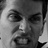

In [126]:
angry = list(traintest_data_dir.glob('angry/*'))
PIL.Image.open(str(angry[3]))

In [127]:
# data
# data_dir = "./dataset"
if TrainModel == True:
    image_extensions = [".png"]  # add there all your images file extensions

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(traintest_data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [128]:
batch_size = traintest_image_count
img_height = 224
img_width = 224

In [129]:
# train data
if TrainModel == True:
    train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
        traintest_data_dir,
        validation_split=0.2,
        subset="both",
        seed=123,
        shuffle= True,
        image_size=(img_height, img_width),
        batch_size=traintest_image_count)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.
Using 300 files for validation.


In [130]:
if TrainModel == True:
    class_names_train = train_ds.class_names
    print(class_names_train)

['angry', 'happy', 'sad']


# Prepare Data

pre-process your raw input data... rescale... normalize....

In [131]:
if TrainModel == True:
    for image_batch, labels_batch in train_ds:
        x_train = image_batch
        y_train = labels_batch
        
    y_train_onehot = tf.keras.utils.to_categorical(y_train, 3)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    y_train_onehot = np.array(y_train_onehot)
    
    x_train = tf.keras.applications.imagenet_utils.preprocess_input(x_train, mode='torch')


In [132]:
if TrainModel == True:
    for image_batch, labels_batch in test_ds:
        x_test = image_batch
        y_test = labels_batch
        
    y_test_onehot = tf.keras.utils.to_categorical(y_test, 3)

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    y_test_onehot = np.array(y_test_onehot)
    
    x_test = tf.keras.applications.imagenet_utils.preprocess_input(x_test, mode='torch')

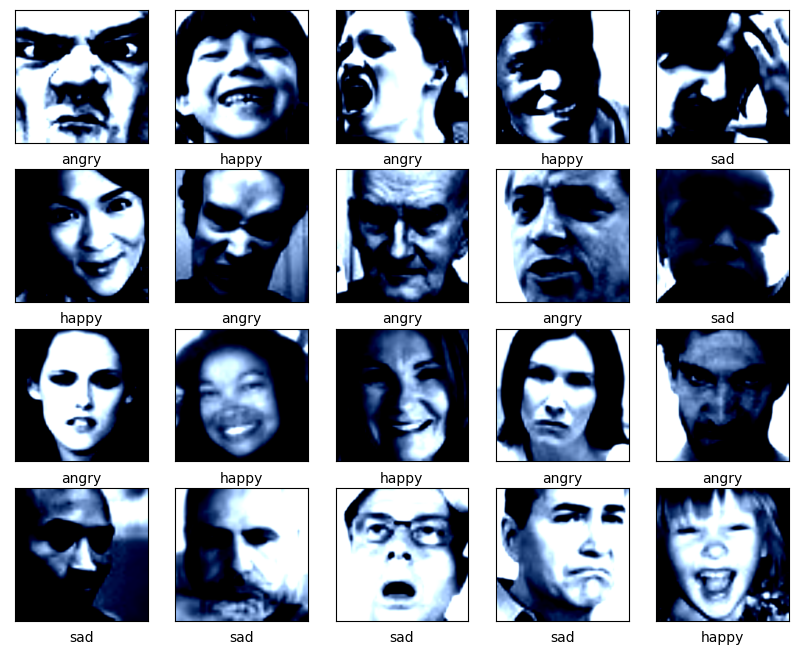

In [133]:
if TrainModel == True:
    plt.figure(figsize=(10,10))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
        plt.xlabel(class_names_train[y_train[i]])
    plt.show()


## Define your Model

With Transfer learning you take a given network model withouth the last layers, you can take the suggested VGG-16 model as decribed on the given website and add the additional layers. 

**NOTE:**
That the Ouput layer should match your input dataset!



* How is your model constructed, how many trainable parameters does it have, and where are they located?

In [134]:
if TrainModel == True:
    base_model = VGG16(weights='imagenet',include_top=False, input_shape=(224,224,3))   ## Loading VGG16 model
    base_model.trainable = False    ## Not trainable weights

    print(base_model.summary())


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [135]:
if TrainModel == True:
    flatten_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(50, activation='relu')
    drop_layer_1 = tf.keras.layers.Dropout(.2, input_shape=(img_height,img_width,3))
    dense_layer_2 = tf.keras.layers.Dense(20, activation='relu')
    prediction_layer = tf.keras.layers.Dense(3, activation='softmax')


    model = tf.keras.models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        drop_layer_1,
        dense_layer_2,
        prediction_layer
    ])

# Fit the Model

Fitting the model is the time consuming part, this depend on the complexity of the model and the amount of training data. With Transfer learning a lot of pre-trained parameters are now 'frozen', this will limit training time (or enables us to train more complex networks with the same processing performance, and so achieving better results)

* Which batch size and how many epochs give a good result?

In [136]:
import keras

if TrainModel == True:
    checkpoint = tf.keras.callbacks.ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', patience=5,  restore_best_weights=True)

    reduce_learningrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=3,
                                verbose=1,
                                min_delta=0.0001)

    callbacks_list = [es, reduce_learningrate]

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    #history = model.fit(x_train, y_train_onehot, epochs=40, validation_data=(x_test, y_test_onehot), batch_size=1, callbacks=[callbacks_list])
    history = model.fit(x_train, y_train_onehot, epochs=10, validation_data=(x_test, y_test_onehot),  callbacks=[callbacks_list])

Epoch 1/10
38/38 [==============================] - 94s 2s/step - loss: 1.1727 - accuracy: 0.4108 - val_loss: 1.0375 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 2/10
38/38 [==============================] - 93s 2s/step - loss: 0.9351 - accuracy: 0.5508 - val_loss: 0.9805 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 3/10
38/38 [==============================] - 98s 3s/step - loss: 0.8333 - accuracy: 0.6075 - val_loss: 0.8685 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 4/10
38/38 [==============================] - 94s 2s/step - loss: 0.6842 - accuracy: 0.6958 - val_loss: 0.8401 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 5/10
38/38 [==============================] - 93s 2s/step - loss: 0.5710 - accuracy: 0.7583 - val_loss: 0.7977 - val_accuracy: 0.6233 - lr: 0.0010
Epoch 6/10
38/38 [==============================] - 90s 2s/step - loss: 0.4586 - accuracy: 0.8058 - val_loss: 0.7982 - val_accuracy: 0.6267 - lr: 0.0010


# Evaluate Model

Show the model accuracy after the training process ... 
* How accurate is your final model?

In [137]:
if TrainModel:
    val_loss, val_acc = model.evaluate(x_test, y_test_onehot, batch_size= 1)
    print(f"Validated loss: {val_loss} , Validated Accuracy: {val_acc}")



300/300 [==============================] - 21s 69ms/step - loss: 1.0375 - accuracy: 0.4933
Validated loss: 1.037466049194336 , Validated Accuracy: 0.4933333396911621


# learning curves

Show the learning curves of your training sequence, of accuracy, value_accuracy and loss, value_loss



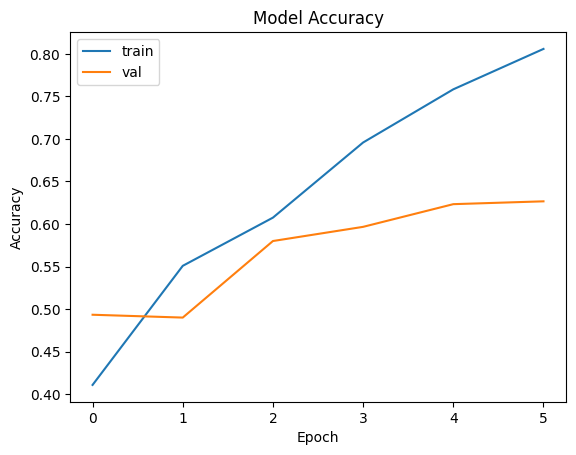

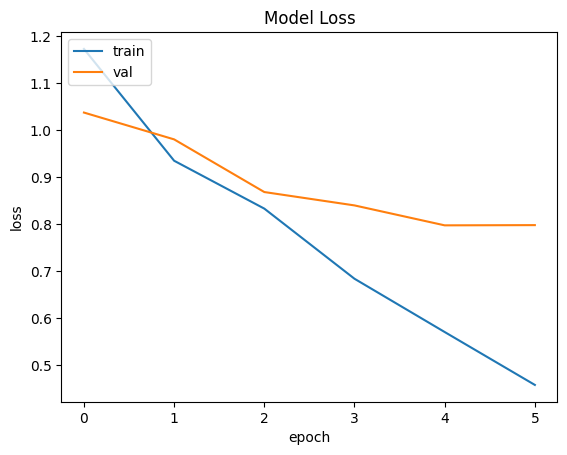

In [138]:
def plotAccuracyVsEpoch(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def plotLossVsEpoch(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

if TrainModel == True:
    plotAccuracyVsEpoch(history)
    plotLossVsEpoch(history)

# Save model

Save the model for later usage

In [139]:
import shutil

if TrainModel == True:
    # remove old account directory
    save_path_model = 'saved_models/model'+ str(model_iteration)
    shutil.rmtree(save_path_model, ignore_errors=True)

    model.save(save_path_model)

INFO:tensorflow:Assets written to: saved_models/model6\assets


INFO:tensorflow:Assets written to: saved_models/model6\assets


# Evaluate Final Model

After training and saving the model you can deploy this model on any given input image. You can start a new application in where you import this model and apply it on any given imput images, so you can just load the model and don't need the timeconsuming training anymore.

In [140]:
test_model = tf.keras.models.load_model(save_path_model)
probability_model = tf.keras.Sequential([test_model, tf.keras.layers.Softmax()])


# Make Prediction

We can use our saved model to make a prediction on new images that are not trained on... make sure the input images receive the same pre-processing as the images you trained on.

So fetch some images from the internet (similar classes, but not from your dataset), prepare them to fit your network and classify them. Do this for  **10 images per class** and show the results!

* How good is the detection on you real dataset? (show some statistics) 

In [141]:
if TrainModel == True:
    prediction_data_dir = pathlib.Path("./dataset/predictions1")

    prediction_image_count = len(list(prediction_data_dir.glob('*/*.png')))

    print('Train set batch size = ' + str(prediction_image_count))

Train set batch size = 30


In [142]:
batch_size = prediction_image_count

prediction_ds = tf.keras.utils.image_dataset_from_directory(
    prediction_data_dir,
    color_mode= 'rgb',
    image_size=(img_height, img_width),
    #shuffle= False,
    batch_size=batch_size,
    class_names = ['angry', 'happy', 'sad'],
    interpolation='nearest')

class_names_prediction = prediction_ds.class_names
print(class_names_prediction)

Found 30 files belonging to 3 classes.
['angry', 'happy', 'sad']


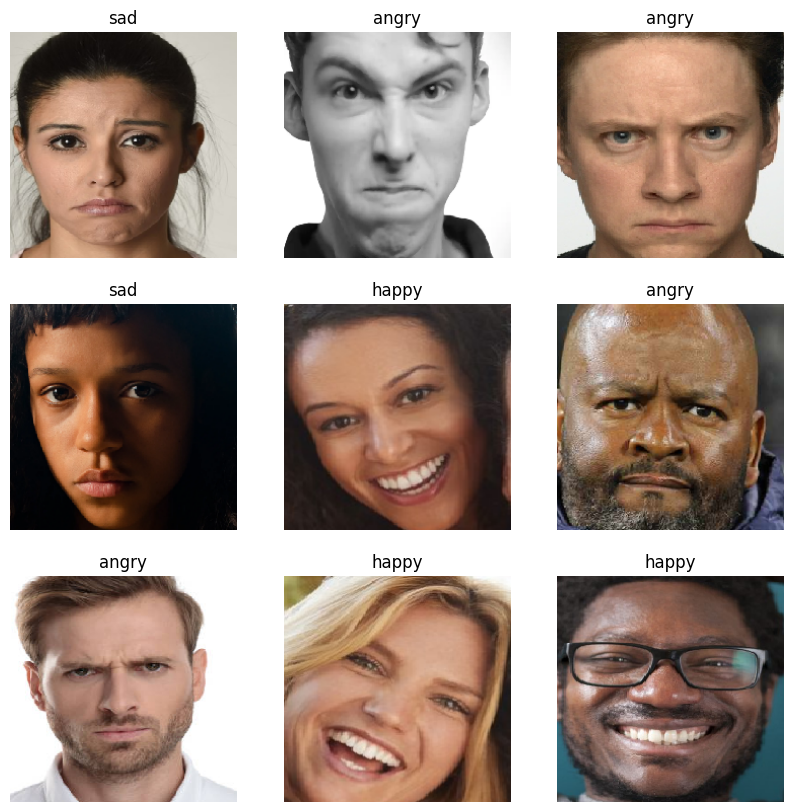

In [143]:
plt.figure(figsize=(10, 10))
for images, labels in prediction_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names_prediction[labels[i]])
        plt.axis("off")

In [144]:
for image_batch, labels_batch in prediction_ds:
    x_validation = image_batch
    y_validation = labels_batch

#x_validation = np.reshape(x_validation, (batch_size,img_height,img_width))
#x_validation = np.array(x_validation / 255)
#y_validation = np.array(y_validation)

#x_validation = x_validation + 1
#x_validation = np.clip(x_validation, a_min=0, a_max=1)

    y_validation_onehot = tf.keras.utils.to_categorical(y_validation, 3)

    x_validation = np.array(x_validation)
    y_validation = np.array(y_validation)
    y_validation_onehot = np.array(y_validation_onehot)
    
    x_validation = tf.keras.applications.imagenet_utils.preprocess_input(x_validation, mode='torch')


In [145]:
predictSource = x_validation
realLabels = y_validation

predictions = probability_model.predict_on_batch(predictSource)
predictionLabels = np.argmax(predictions, axis=1)

In [146]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

  thisplot[true_label].set_color('blue')

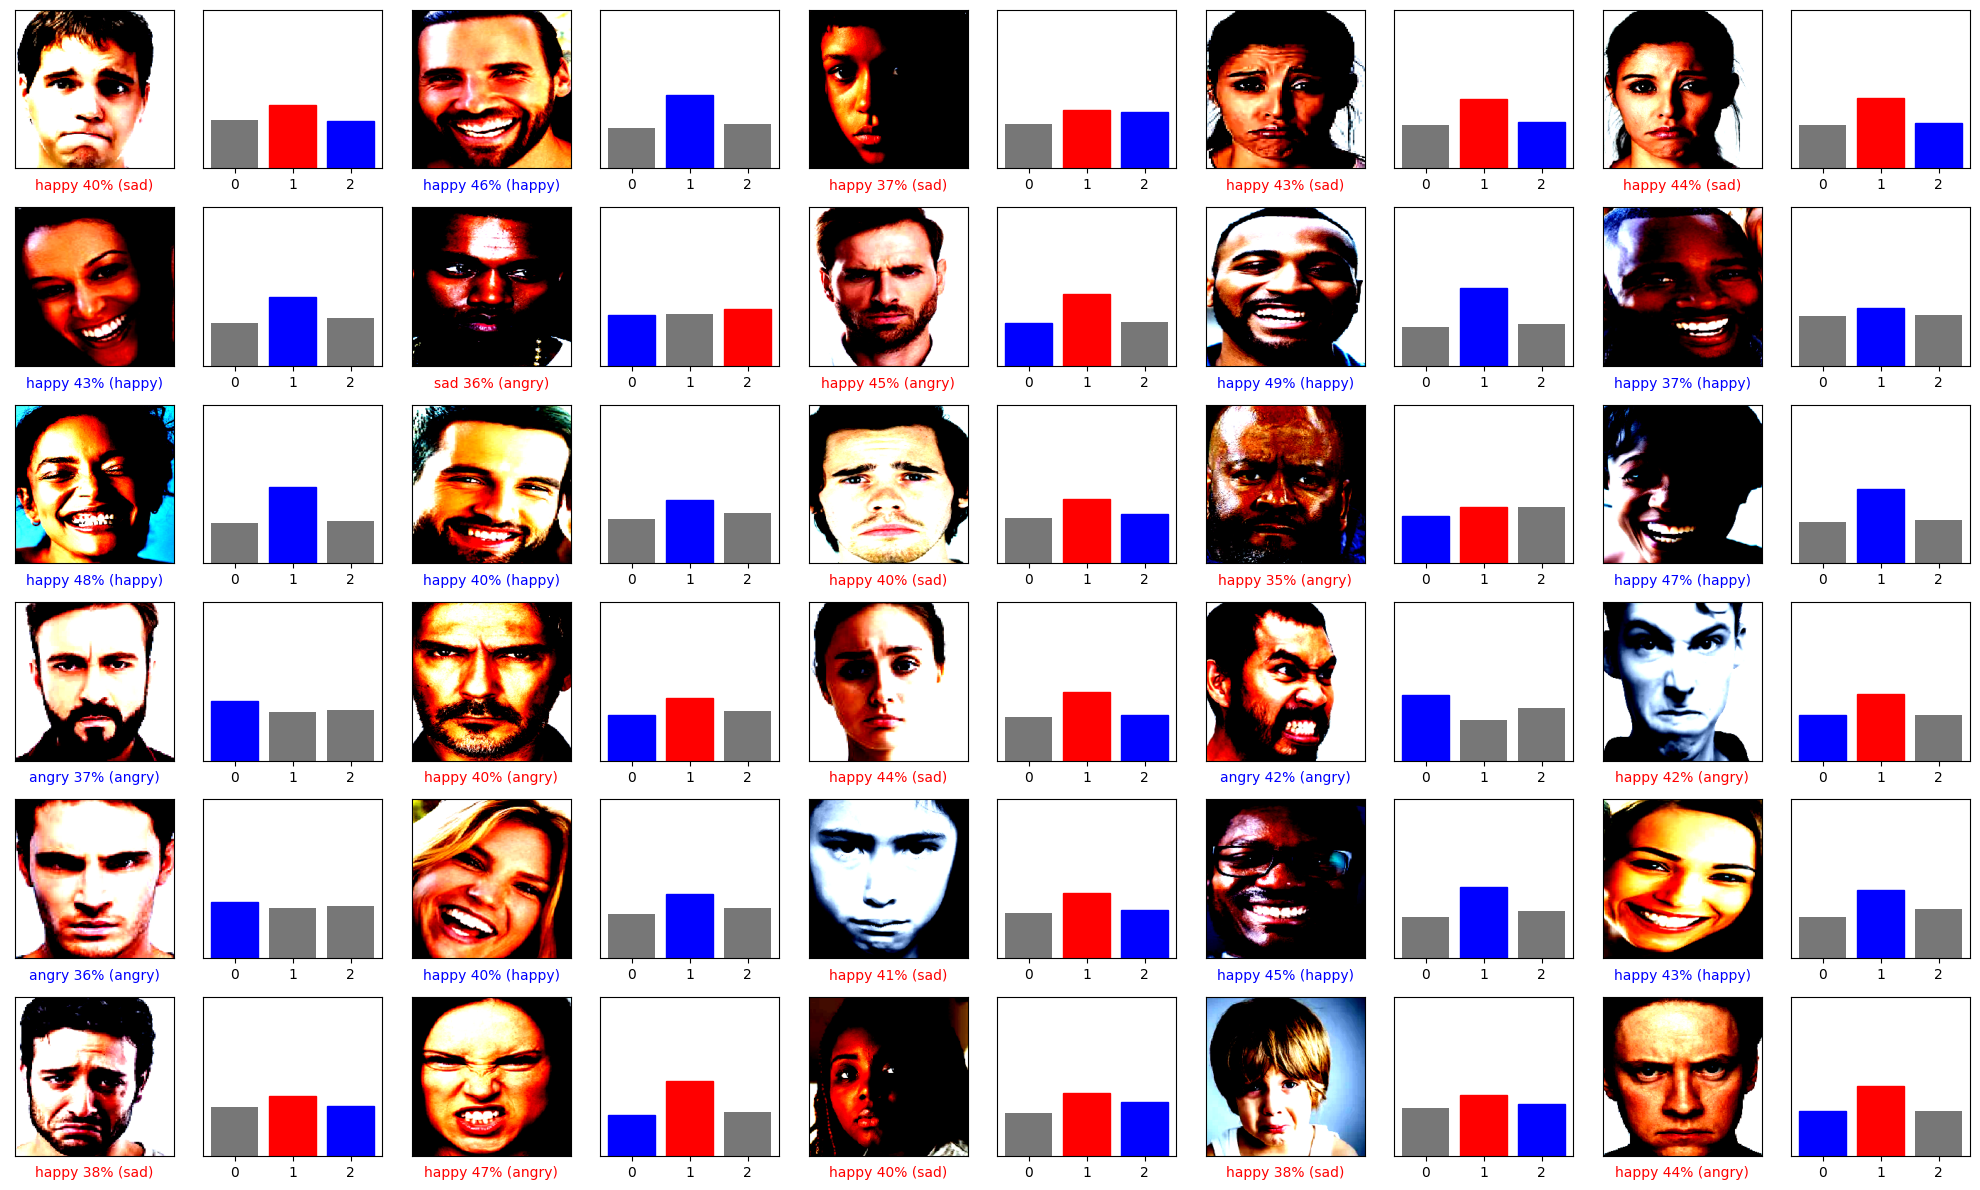

In [147]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 6
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], realLabels, predictSource)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], realLabels)
plt.tight_layout()
plt.show()

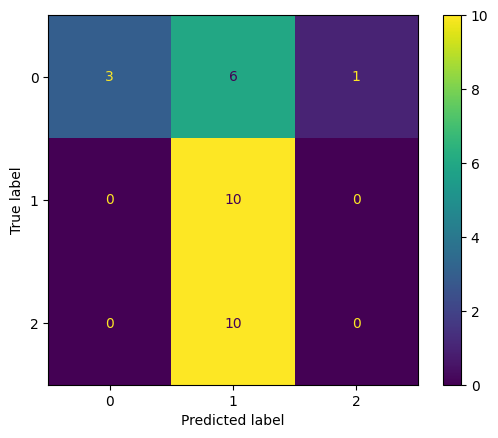

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(realLabels, predictionLabels)
ConfusionMatrixDisplay(cm).plot()

In [149]:
val_loss, val_acc = model.evaluate(predictSource, tf.keras.utils.to_categorical(realLabels),batch_size= 1)
print(f"Validated loss: {val_loss} , Validated Accuracy: {val_acc}")

30/30 [==============================] - 2s 69ms/step - loss: 1.0709 - accuracy: 0.4333
Validated loss: 1.070943832397461 , Validated Accuracy: 0.4333333373069763


# Additional Questions
* Explain what your input object represents and how the result should be classified
* Explain the pre-processing steps of the object training image(s) before you can feed it to the network.
* What features do you think are extracted (relevant)?
* Show (in report and video) how accurate your predicted model is, how does your detection behave in other unseen situations? Also explain in what situation and why it does (not) perform well. Supported your statements by measurement data!
* Explain the parameters that you used for re-training this network?
* This example uses a custom (but pre-trained) network architecture, explain how it works and why it is build up this way?

## Finetuning
Finetuning by retraining all weights in the network as described in the workflow is Optional, but this will lead to a better accuracy of your final model,